# Bank Loan Approval

## Main Goals

- Predict whether a loan will be approved based on customer data
- Handle outliers
    - Determine whether to use log transformations or capping
- Create interaction terms
- Apply feature scaling
- Compare and analyze results from two different models.

### Context

Access to credit is a cornerstone of personal and business finance, yet the loan approval process presents a significant challenge for financial institutions in balancing opportunity with risk. Making accurate and fair credit decisions is crucial for minimizing loan defaults while also promoting financial inclusion. In the field of data science, predictive modeling offers a robust tool for assessing an applicant's creditworthiness with consistency and scale. This project leverages a real-world dataset of past loan applications to build a classification model that predicts approval status based on key financial and demographic data, enabling a more data-driven approach to lending.

## 1. Loading in the Data

For this project, we will use the [Loan Approval Classification Dataset](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data) from Kaggle. In accordance with Kaggle licenses, please directly visit the Kaggle website and download the `loan_data.csv` dataset for this activity, and then upload the file to the same directory as the notebook file.

We can start by loading in the dataset into a pandas dataframe, and then displaying it to ensure it loaded correctly, and so we can see what the features are and how the target is displayed. This means that we have to start by importing pandas as well.

It's worth mentioning that anytime you have a dataset from an external source, such as Kaggle, you can and should refer back to the source of the data to clear up misconceptions and also to get a better understanding of the data.

In [1]:
#Import Pandas 
import pandas as pd

#Read the CSV file
df = pd.read_csv('loan_data.csv')

#Display the data
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


### Understanding the data

Displaying our data allows us to see that our data has loaded in properly, as well as what feaatures we have. Using both information from this displayed dataframe, as well as information from the source of the data, which in this case is Kaggle, we'll take note and clarify some of these features.

- `person_education`: Highest education level
- `person_emp_exp`: Number of years of employment experience 
- `loan_percent_income`: Loan amount as a percentage of annual income
- `cb_person_cred_hist_length`: Length of credit history in years
- `previous_loan_defaults_on_file`: Indicator of previous loan defaults.
- `loan_status`: Loan approval status. This will be our target.

With our data cleared up a bit, we can start to clean it as well.


## 2. Preprocessing
Having taken a good look at the data, we can now start to clean it. Before we split the data or build the model, it is important to make sure the data is ready for the model and any other transformations. 

### Handling Null Values
A good habit to keep when cleaning data is to start by looking for any null entries. They can cause problems for whatever model we use later on, so it's important to check for them and deal with them appropiately.

In [2]:
#Check for missing values
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

Fortunately for us however, this dataset is completely filled. Just remember, unless it's explicitly stated that the data has been cleaned in a certain way already, do not skip this step.

### Handling Potential Data Leakage
Something we have to be careful of is any features besides the target that won't be available to us at prediction time. In our case, that's the loan interest rate. For many loans, the interest rate is set after the loan is approved, and as such could give information to the model that wouldn't normally be available at prediction time. While not all loans are like this, our dataset unfortunately does not specify, and as such, we'll take the necessary precaution of dropping loan_int_rate to avoid data leakage.

In [3]:
#Drop the 'loan_int_rate' column
df = df.drop(columns=['loan_int_rate'])

### Encoding Categorical Features
Our next step in cleaning the data is encoding our categorical features. Most models prefer our data in numerical or boolean format, so we'll have to turn our categorical features into numerical. For features with just two possible outputs, we'll map those possible outputs to either a 1 or a 0, effectively turning the feature into a binary feature. For features with more than two possible values, we'll use one-hot encoding, creating a new feature for every possible value. 

We'll start with label encoding by putting the categorical features we want as binary in a list and then using the .map function to change the values. We'll then use pandas's .get_dummies function to do the one-hot encoding for us.

In [4]:
#Put categorical features we want as binary variables in a list
binary_cols = ['person_gender', 'previous_loan_defaults_on_file']

#Convert categorical features to binary variables
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'male': 1, 'female': 0})
    
df = pd.get_dummies(df, columns=['person_education', 'person_home_ownership', 'loan_intent'])

#Display the updated DataFrame
display(df)

,person_age,person_gender,person_income,person_emp_exp,loan_amnt,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,0,71948.0,0,35000.0,0.49,3.0,561,0,1,...,False,False,False,True,False,False,False,False,True,False
1,21.0,0,12282.0,0,1000.0,0.08,2.0,504,1,0,...,False,False,True,False,False,True,False,False,False,False
2,25.0,0,12438.0,3,5500.0,0.44,3.0,635,0,1,...,True,False,False,False,False,False,False,True,False,False
3,23.0,0,79753.0,0,35000.0,0.44,2.0,675,0,1,...,False,False,False,True,False,False,False,True,False,False
4,24.0,1,66135.0,1,35000.0,0.53,4.0,586,0,1,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,1,47971.0,6,15000.0,0.31,3.0,645,0,1,...,False,False,False,True,False,False,False,True,False,False
44996,37.0,0,65800.0,17,9000.0,0.14,11.0,621,0,1,...,False,False,False,True,False,False,True,False,False,False
44997,33.0,1,56942.0,7,2771.0,0.05,10.0,668,0,1,...,False,False,False,True,True,False,False,False,False,False
44998,29.0,1,33164.0,4,12000.0,0.36,6.0,604,0,1,...,False,False,False,True,False,True,False,False,False,False


Displaying our data shows us that we were able to successfully encode all of the categorical features. They are either in a boolean or numerical format, which models will have an easier time reading.

That's it for preprocessing for now. Remaining changes such as scaling, creating interaction terms, or applying transformations needs to happen after splitting the data into training and testing sets.


## 3. Visualizing the Data.
In order to get a better understanding of the data, as well as to see which features might be ideal for creating interaction terms, we can graph out our features and see what correlations might be apparent. Additionally, seeing how many outliers exist in the data, we can determine whether we would want to apply logarthim transformations or cap the data. We'll worry about the when we get there. Let's graph out the data for now.

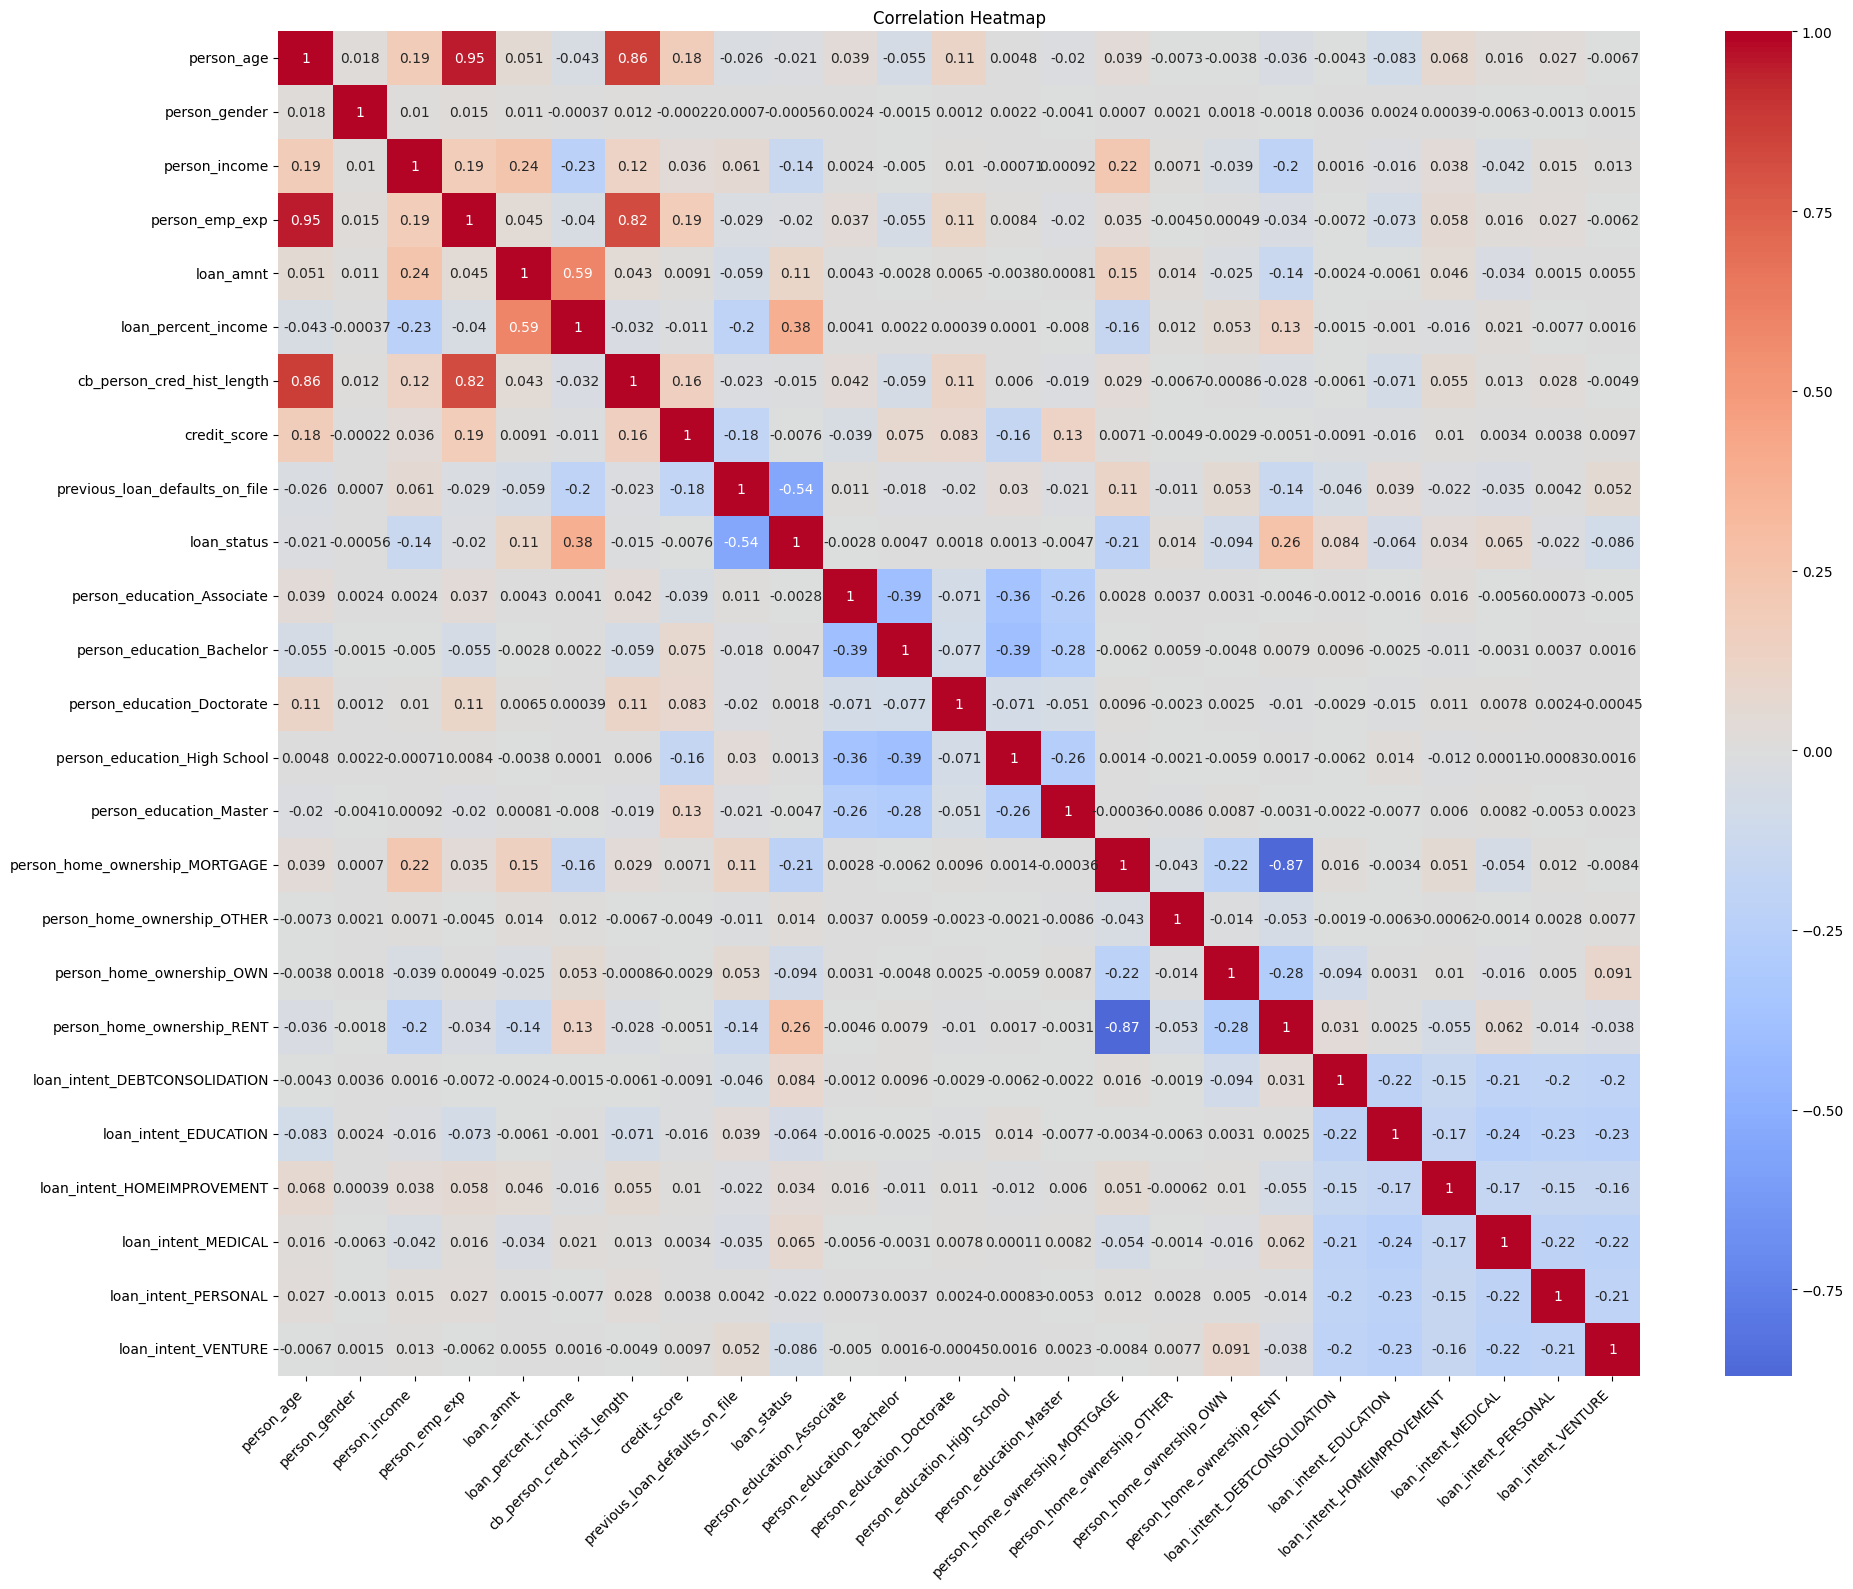

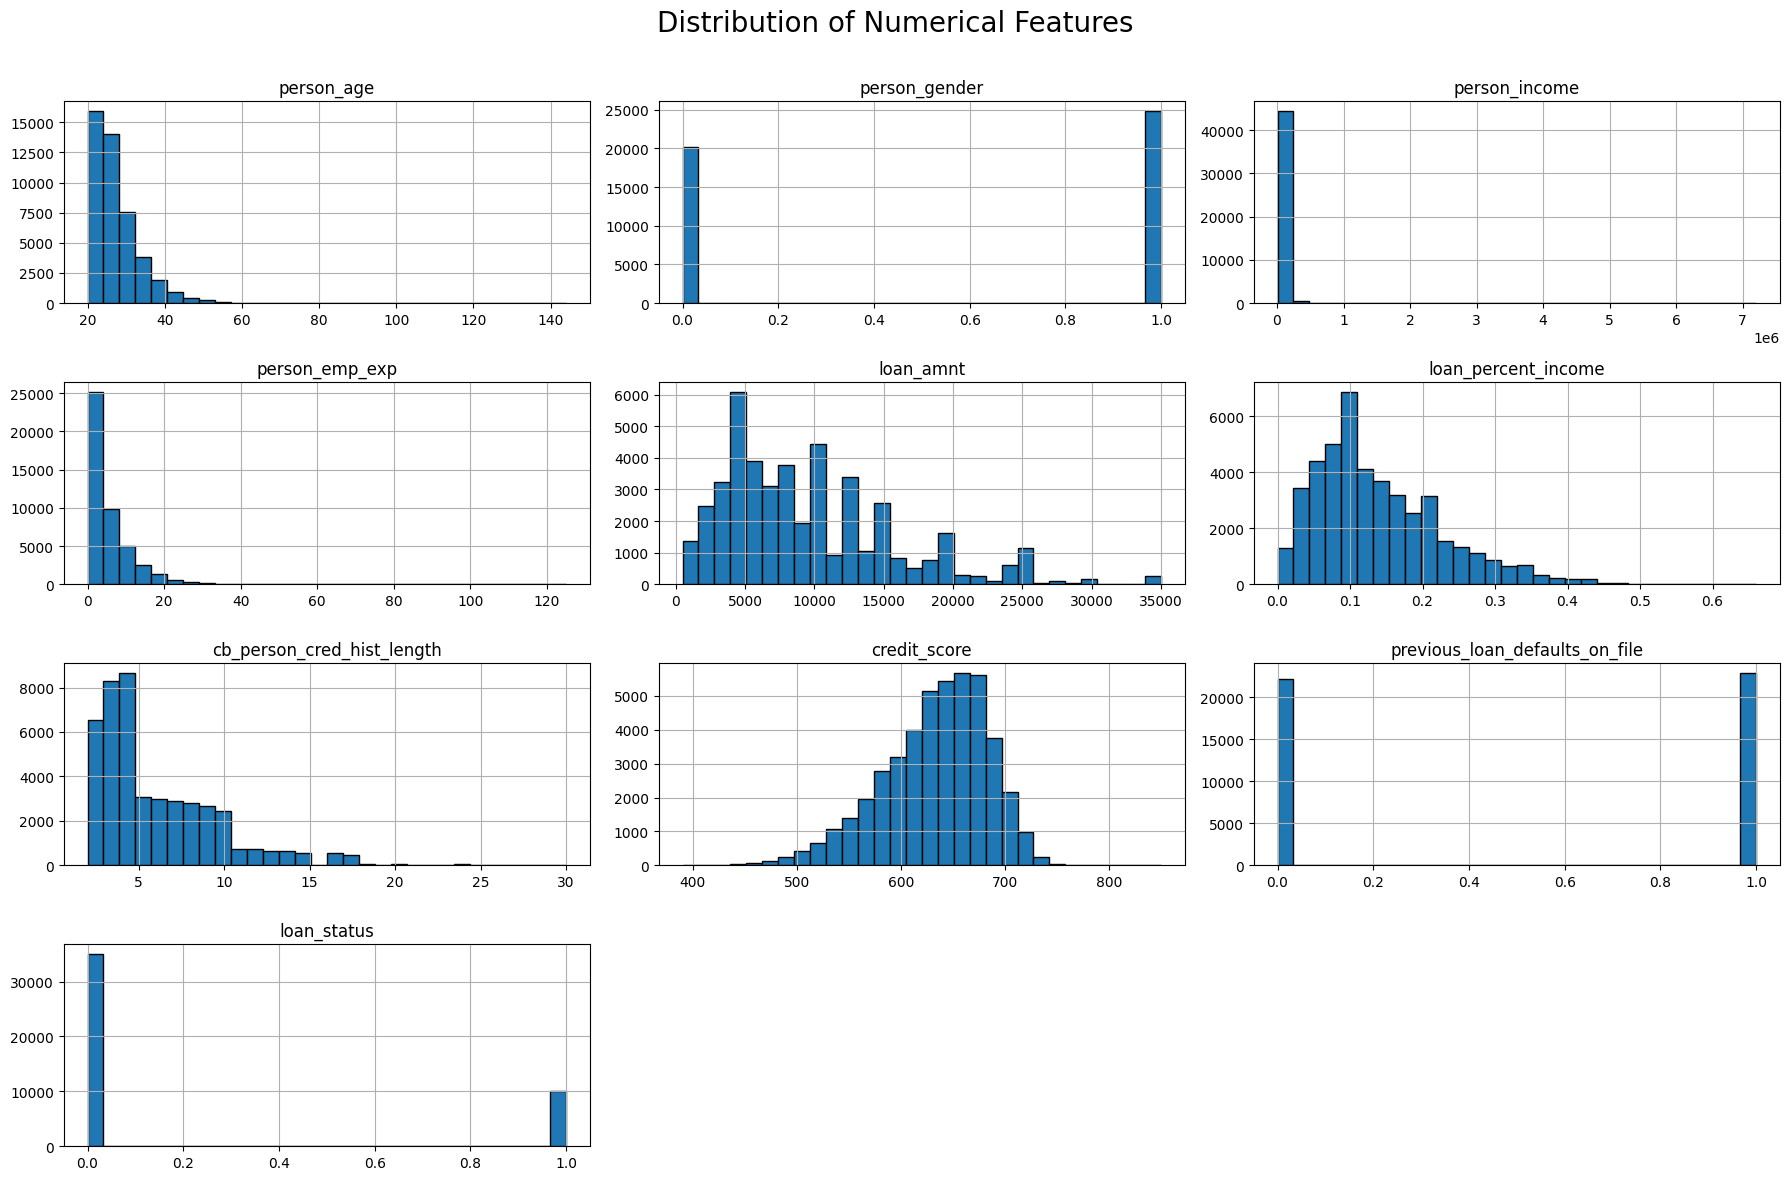

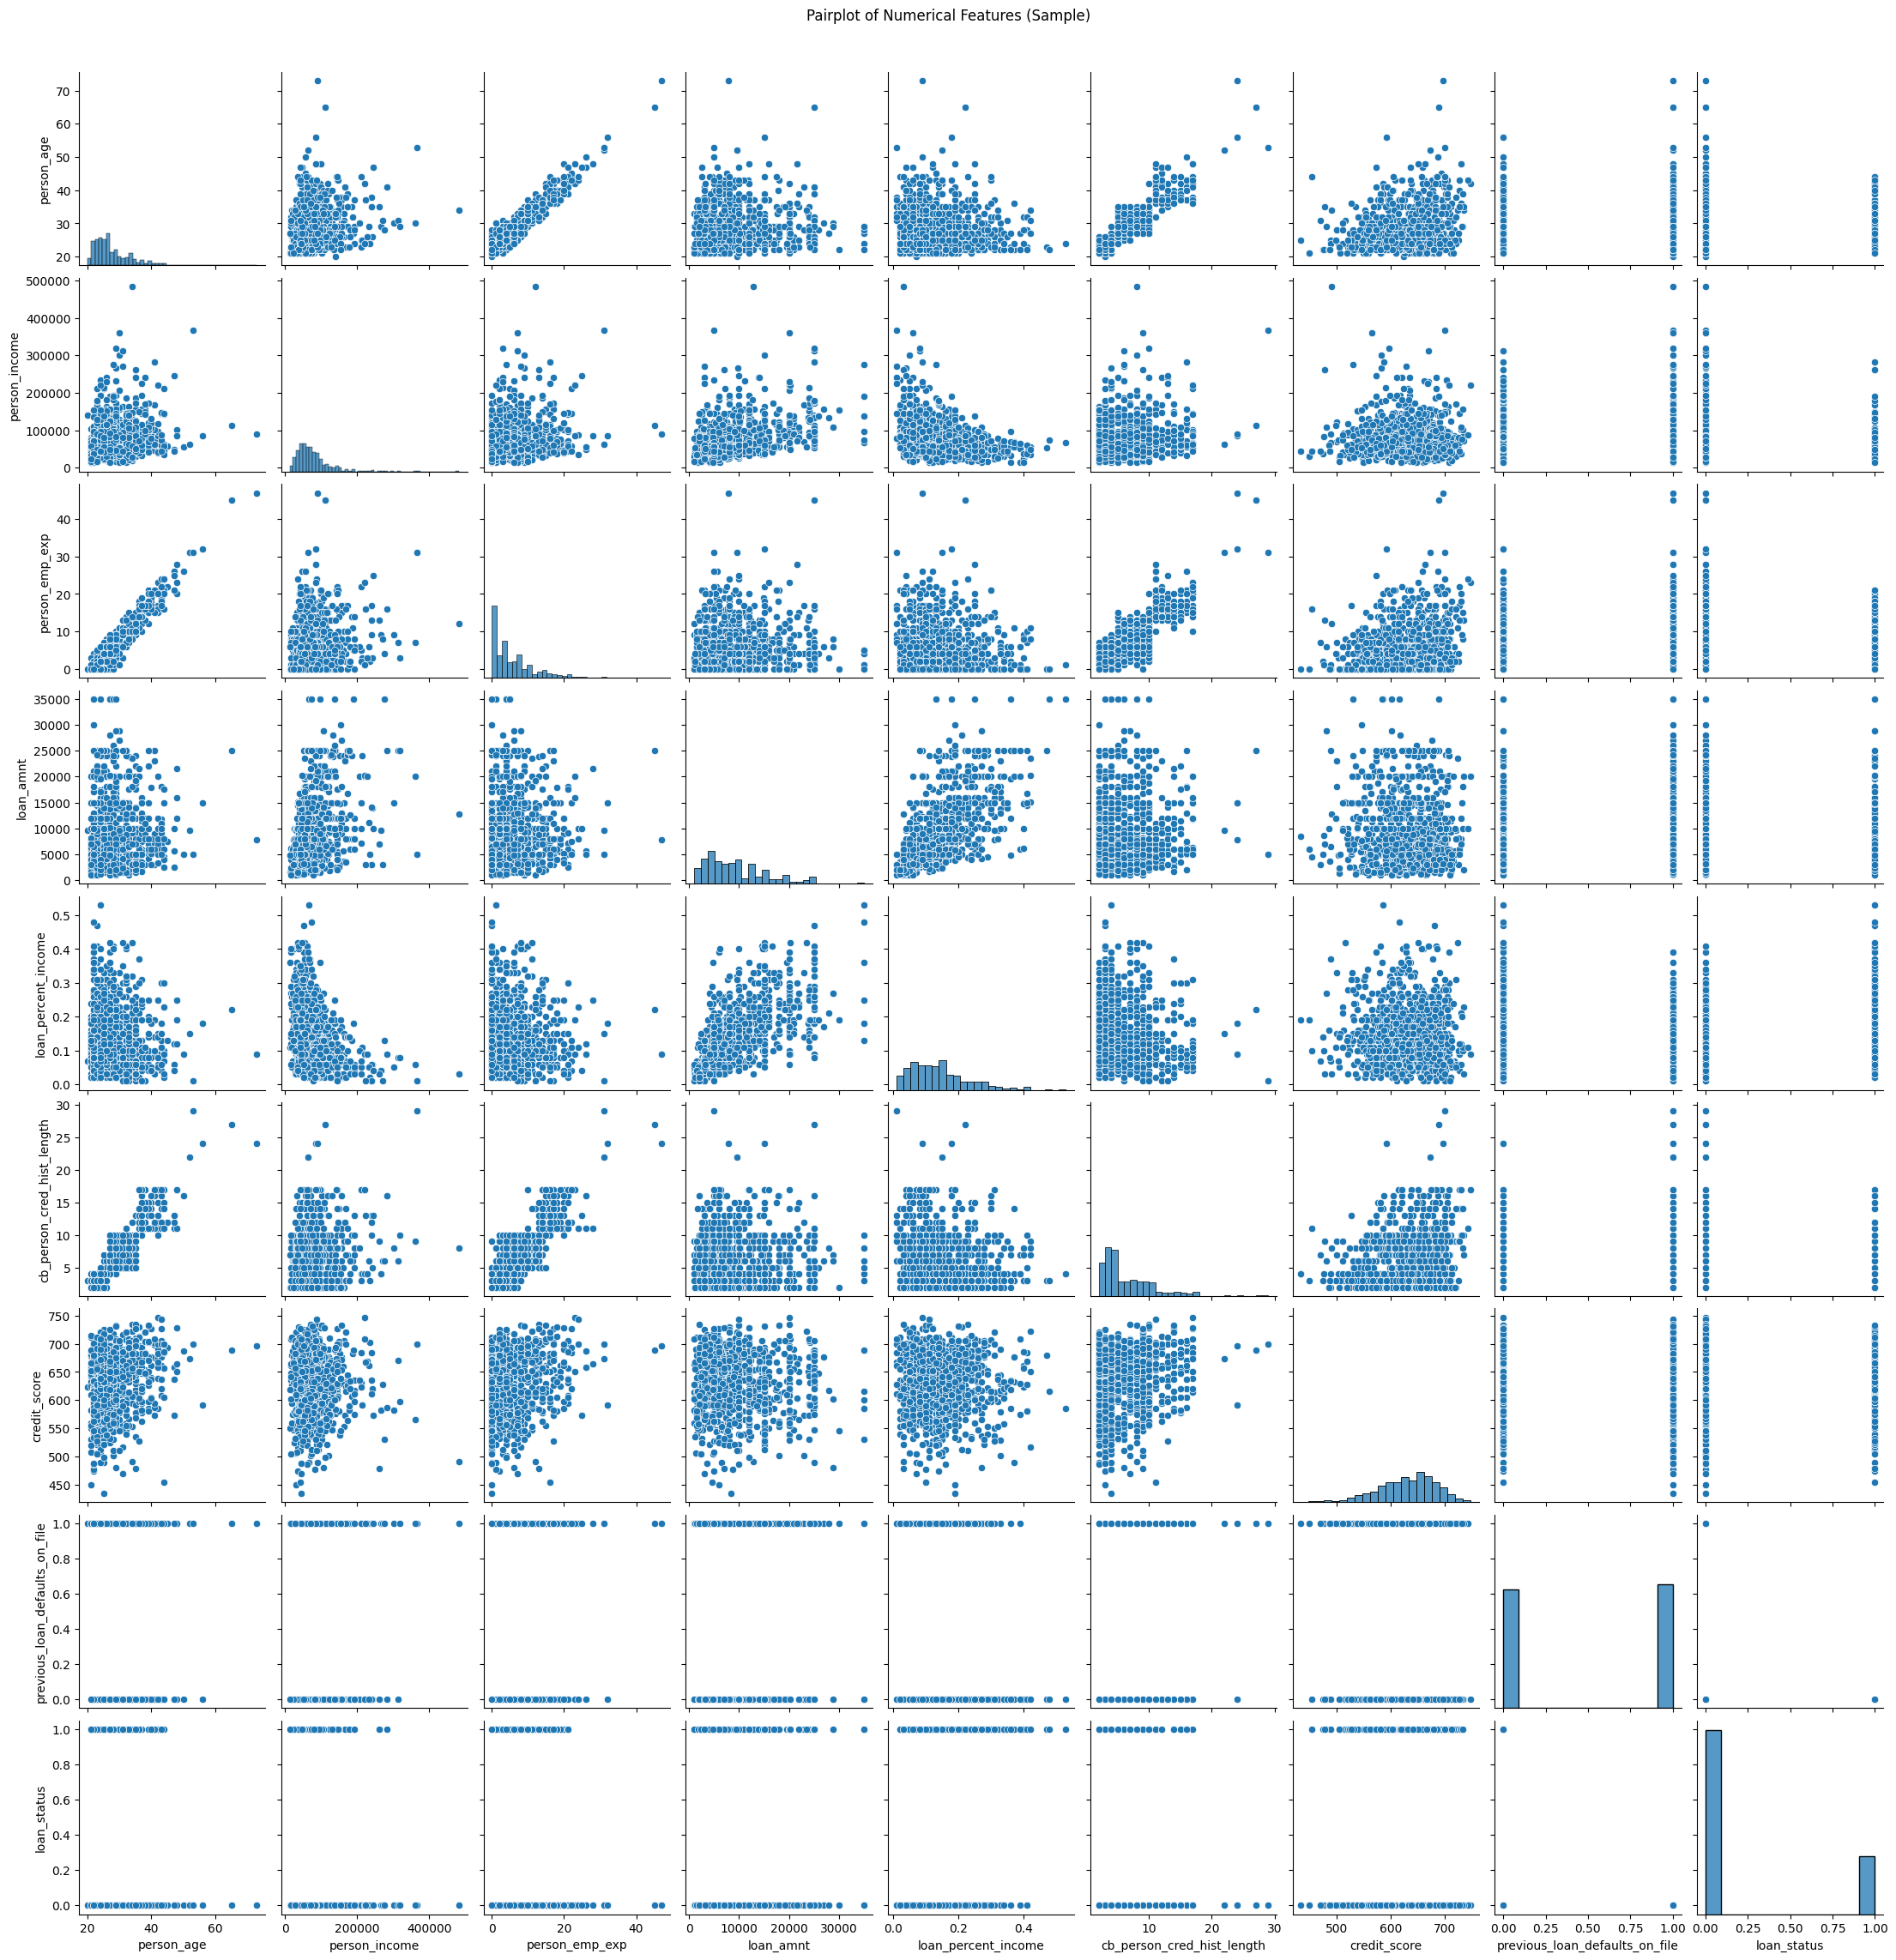

In [5]:
#Import seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Create correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Visualize distributions of all numerical features to spot outliers
#Plot histograms for each numerical feature
df.hist(figsize=(18, 12), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#Pairplot for a subset of features (for outlier and relationship visualization)
#For this, start by manually selecting a few numerical features
numerical_cols = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score',
    'previous_loan_defaults_on_file',
    'loan_status'
]

#Create the pairplot
sns.pairplot(df[numerical_cols].sample(1000, random_state=42))  #sample for speed. 45k points among many features can hurt.
plt.suptitle('Pairplot of Numerical Features (Sample)', y=1.02)
plt.show()

A close look at our data shows some very useful clues for predicting loan defaults and points out a couple of key issues we need to fix. The graphs reveal that things like a person's home ownership and the reason for the loan are strongly linked to whether they default. The heatmap also confirms a powerful connection between credit scores and interest rates: as scores go up, rates go down. The two main challenges we found are that important numbers like applicant income are heavily skewed to one side, and that there are far more non-defaulted loans than defaulted ones. This means we'll need to use log transformations to balance out the skewed numbers and adjust our model's settings to make sure it gets good at spotting the rare default cases.

## 4. Interaction Terms

Now that we have a good feel for our data from looking at the graphs, we can move on to another step in feature engineering: creating interaction terms. These are new, more powerful features that we build by combining two or more existing ones, usually by multiplying them together. The goal is to capture a special, combined effect that the model might not see from the individual features alone. For example, instead of just looking at credit_score and loan_intent separately, we can see if a good credit score matters more for certain types of loans. Based on the interesting relationships we found in the heatmap, our plan is to create these new features by multiplying the most promising pairs, giving our model even smarter clues to use when making its predictions. Below are the interaction features we plan to create, and our reasoning for them as well.

- `credit_score` * `loan_intent_MEDICAL`

    - The graphs showed that medical loans tend to have higher interest rates, suggesting they're seen as riskier. This feature helps the model check if a good credit score has a different level of importance specifically when the loan is for a medical reason.

- `person_income` * `person_home_ownership_RENT`

    - We saw that renters tend to have higher default rates. This feature tests if having a high income can help offset the risk associated with being a renter, allowing the model to treat a high-income renter differently from a low-income renter.

- `credit_score` * `previous_loan_defaults_on_file_Yes`

    - A previous default is a huge red flag, but a high current credit score is a strong positive signal. This feature directly combines these two powerful but opposing factors to help the model decide which one is more important for a given applicant.

- `loan_percent_income` * `loan_intent_VENTURE`

    - Business venture loans are likely very different from personal loans. This feature lets the model learn if the applicant's debt-to-income ratio (loan_percent_income) should be treated more or less strictly when the loan is for a business.

- `person_emp_exp` / `person_age`

    - This creates a "career stability" score. We expect older people to have more experience. This feature helps the model spot applicants who don't fit that pattern (e.g., an older person with very little work experience), which could be a subtle sign of risk.

- `loan_amnt` * `person_education_Master`
    - This tests if having a Master's degree makes a lender more willing to approve a larger loan. It’s based on the idea that a Master's degree signals strong future earning potential, making an applicant seem like a safer bet for a bigger loan than their current income alone might show.

In [6]:
#Create interaction terms as described

#credit_score * loan_intent_MEDICAL
df['credit_score_x_loan_intent_MEDICAL'] = df['credit_score'] * df['loan_intent_MEDICAL']

#person_income * person_home_ownership_RENT
df['person_income_x_home_ownership_RENT'] = df['person_income'] * df['person_home_ownership_RENT']

#credit_score * previous_loan_defaults_on_file
df['credit_score_x_prev_loan_default'] = df['credit_score'] * df['previous_loan_defaults_on_file']

#loan_percent_income * loan_intent_VENTURE
df['loan_percent_income_x_loan_intent_VENTURE'] = df['loan_percent_income'] * df['loan_intent_VENTURE']

#person_emp_exp / person_age
df['emp_exp_per_age'] = df['person_emp_exp'] / df['person_age']#.replace(0, 1)

#loan_amnt * person_education_Master
df['loan_amnt_x_education_Master'] = df['loan_amnt'] * df['person_education_Master']

#Display the DataFrame with interaction terms
display(df)

#Print out the names of the columns to see all feature names
df.columns.tolist()

,person_age,person_gender,person_income,person_emp_exp,loan_amnt,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,credit_score_x_loan_intent_MEDICAL,person_income_x_home_ownership_RENT,credit_score_x_prev_loan_default,loan_percent_income_x_loan_intent_VENTURE,emp_exp_per_age,loan_amnt_x_education_Master
0,22.0,0,71948.0,0,35000.0,0.49,3.0,561,0,1,...,False,False,True,False,0,71948.0,0,0.0,0.000000,35000.0
1,21.0,0,12282.0,0,1000.0,0.08,2.0,504,1,0,...,False,False,False,False,0,0.0,504,0.0,0.000000,0.0
2,25.0,0,12438.0,3,5500.0,0.44,3.0,635,0,1,...,False,True,False,False,635,0.0,0,0.0,0.120000,0.0
3,23.0,0,79753.0,0,35000.0,0.44,2.0,675,0,1,...,False,True,False,False,675,79753.0,0,0.0,0.000000,0.0
4,24.0,1,66135.0,1,35000.0,0.53,4.0,586,0,1,...,False,True,False,False,586,66135.0,0,0.0,0.041667,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,1,47971.0,6,15000.0,0.31,3.0,645,0,1,...,False,True,False,False,645,47971.0,0,0.0,0.222222,0.0
44996,37.0,0,65800.0,17,9000.0,0.14,11.0,621,0,1,...,True,False,False,False,0,65800.0,0,0.0,0.459459,0.0
44997,33.0,1,56942.0,7,2771.0,0.05,10.0,668,0,1,...,False,False,False,False,0,56942.0,0,0.0,0.212121,0.0
44998,29.0,1,33164.0,4,12000.0,0.36,6.0,604,0,1,...,False,False,False,False,0,33164.0,0,0.0,0.137931,0.0


['person_age',
 'person_gender',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'credit_score',
 'previous_loan_defaults_on_file',
 'loan_status',
 'person_education_Associate',
 'person_education_Bachelor',
 'person_education_Doctorate',
 'person_education_High School',
 'person_education_Master',
 'person_home_ownership_MORTGAGE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'credit_score_x_loan_intent_MEDICAL',
 'person_income_x_home_ownership_RENT',
 'credit_score_x_prev_loan_default',
 'loan_percent_income_x_loan_intent_VENTURE',
 'emp_exp_per_age',
 'loan_amnt_x_education_Master']

From the displayed column names, though truncated, we were able to add the interaction terms to our dataset. These interaction terms will likely help our models predict more precisely.

Don't worry about having too many features, as we are still fine in that regard. Typically, if you have 10 features, you would want over 200 entires. Or for every for every feature, aim to have more than 20 entries. 

## 5. Train Test Split
With our feature engineering complete, it's time to move on to the train test split. We want to split our data into training and testing so that there is a set of data our model can learn from, and a set of data to practice against. We can do this simply using the train_test_split module from Sklearn. 

Before doing the split, we'll also separate our target, loan_status, from our remaining features.

Let's start by importing the train_test_split module, and then use it to split our data into 80% training data and 20% testing data.

In [7]:
#import the train_test_split function
from sklearn.model_selection import train_test_split

#Split the data into training and testing sets
X = df.drop(columns=['loan_status'])    
y = df['loan_status']

#Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

## 6. Feature Transformations

With our data split into training and testing, we can now go ahead and perform our scaling transformations. We'll start with log transformations. The idea is that certain features are had significant outliers and were generally skewed more to the right. Since many models tend to give more weight to larger values, applying log transformations allows us to effectively lessen the impact of heavy outliers while still keeping the meaning of the data. After words, we'll further scale the data through normalization, making the mean of the features 0, and the standard deviation 1. This keeps all features in the same range without impacting the meaning of the data as well.

### Logarithm Transformations
We start with logarithm transformations since normalization will bring negative values into the dataframe, and that could possibly interefere with the logarithm transformations.

We'll start by importing Numpy for the logarithm function, identifying skewed columns, and then applying the transformation.

In [8]:
#Import numpy
import numpy as np

#Based on the graphs, we can identify skewed features
skewed_cols = [
    'person_age', 
    'person_income', 
    'person_emp_exp', 
    'loan_amnt', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
] 

#Apply log transformation to skewed features in both training and testing sets
X_train[skewed_cols] = np.log1p(X_train[skewed_cols])
X_test[skewed_cols] = np.log1p(X_test[skewed_cols])


### Normalization

With our logarithm transformation complete, we can now do our normalization as well. Note that while the logarithm transformation was applied on columns that were seemingly skewed, the normalization process will be applied on all features besides the binary ones. Since binary features are currently just 1 or 0, scaling these would actually make them lose meaning, and hurt our model in the long run.

Start by importing StandardScaler from Sklearn, fit the object on the training data, and then transform both the training and testing data. We only fit on the training data to avoid any data leakage with the testing data, and giving our models access to information it wouldn't typically have.

In [9]:
#Import StandardScaler from Sklearn
from sklearn.preprocessing import StandardScaler

#Initialize the StandardScaler object
scaler = StandardScaler()

#Fit the scaler on the training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

With these transformations complete, we have done everything that we needed to in order to completely preprocess our data. It's now time to actually start building a model.

## 7. Building and Training our Models

Alright, now that our data is fully prepped and cleaned, we can move on to building and training our models. For this project, we'll use two different and powerful models, a Random Forest and an XGBoost classifier. Using both lets us directly compare their performance to see which one does a better job on our specific data. Random Forest is great because it's very robust and forgiving with how you set the parameters, while XGBoost is famous for often achieving the absolute best performance with optimal parameters. 

We'll import the model classes from their libraries, create an instance of each, and then train them on our data using the .fit() method. Note that while the XGB Classifier comes from a different library than the random forest and many of the other models we've imported, it has many of the same methods so as to be familiar.

In [10]:
#Import both RandomForestClassifier and XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Initialize the RandomForestClassifier
random_Forest = RandomForestClassifier(n_estimators=100, random_state=64)

#Initialize the XGBClassifier
xgb_Classifier = XGBClassifier(n_estimators=100, random_state=64)

#Fit both classifiers on the training data
random_Forest.fit(X_train_scaled, y_train)
xgb_Classifier.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

## 8. Testing and Improving the Models

With our base models ready, we are ready to test both models! However, don't be surprised if our models don't perform well on the first attempt. We'll take a look at our scores, fine-tune the parameters or use the tools available to us to, and aim to improve our models if they aren't doing well enough. 

Let's first start by importing some metrics of success for both models, and evaulate our models. Note that while the XGB classifier comes from a different library, we can still use the metrics from Sklearn to evaluate it.

In [11]:
#Import our metrics of success
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Make predictions using both classifiers
rf_predictions = random_Forest.predict(X_test_scaled)
xgb_predictions = xgb_Classifier.predict(X_test_scaled)

#Check the accuracy of both classifiers
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))

#Display confusion matrices for both classifiers
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))

#Display classification reports for both classifiers
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))


Random Forest Accuracy: 0.895
XGBoost Accuracy: 0.9022222222222223
Random Forest Confusion Matrix:
 [[6711  247]
 [ 698 1344]]
XGBoost Confusion Matrix:
 [[6666  292]
 [ 588 1454]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      6958
           1       0.84      0.66      0.74      2042

    accuracy                           0.90      9000
   macro avg       0.88      0.81      0.84      9000
weighted avg       0.89      0.90      0.89      9000

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      6958
           1       0.83      0.71      0.77      2042

    accuracy                           0.90      9000
   macro avg       0.88      0.84      0.85      9000
weighted avg       0.90      0.90      0.90      9000



Both models are doing suprisingly well off bat. The lower recall scores does mean that they are having a hard time accurately predicting who deserves a loan, but the f1-score indicates that both models are doing well overall regardless. Now while there isn't much we can do in terms of parameters to improve our random forest, our XGB classifier has many parameters that can be tuned in order to gain better results, and there are functions available to us as well to allow us to figure out what to improve.

The following code segment will be longer than usual, so please do take care and follow along with the comments.

In [ ]:
#Import GridSearchCV from sklearn
from sklearn.model_selection import GridSearchCV

# Calculate scale_pos_weight parameter for XGBoost
#This is tells our model the class imbalance ratio, allowing it to adjust its learning accordingly.
target_counts = y_train.value_counts()
scale_pos_weight_value = target_counts[0] / target_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")


#Set up and Run GridSearchCV, it's a tool that helps us find the best hyperparameters for our model.
#Define the Parameter Grid to search
#These are the XGBoost settings we want to test.
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

#Create a NEW XGBoost Model instance for the search
#We use our calculated scale_pos_weight.
#It's good practice to create a new model instance for GridSearch.
xgb_for_grid = XGBClassifier(
    scale_pos_weight=scale_pos_weight_value,
    random_state=64,
    objective='binary:logistic', # Good to be explicit for classification
    use_label_encoder=False,     # Suppresses a deprecation warning
    eval_metric='logloss'        # Suppresses a default metric warning
)

#Create the GridSearchCV object
#It will test combinations of settings, optimizing for F1 score.
grid_search = GridSearchCV(
    estimator=xgb_for_grid,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

#Fit the Grid Search to your training data
#This step could possibly take a while depending on your hardware
print("\nStarting Grid Search... This might take a while.")
grid_search.fit(X_train_scaled, y_train)

#Print the best results found by the search
print(f"Best F1 Score from Cross-Validation: {grid_search.best_score_:.4f}")
print("Best Parameters Found:")
print(grid_search.best_params_)

Calculated scale_pos_weight: 3.52

Starting Grid Search... This might take a while.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\hsing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:19:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Grid Search Complete ---
Best F1 Score from Cross-Validation: 0.7636
Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


With this, we have found a set of more optimal weights for our XGB classifier, so let's try them out.

In [ ]:
#Create the final XGBoost model with the best parameters found
XGB_final= XGBClassifier(
    scale_pos_weight=scale_pos_weight_value,
    random_state=64,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=1.0
)

#fit the final model with the best parameters
XGB_final.fit(X_train_scaled, y_train)

#Make predictions with the final model
final_predictions = XGB_final.predict(X_test_scaled)

#Check the accuracy of the final model
print("Final XGBoost Model Accuracy:", accuracy_score(y_test, final_predictions))

#Display the confusion matrix for the final model
print("Final XGBoost Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))

#Display the classification report for the final model
print("Final XGBoost Classification Report:\n", classification_report(y_test, final_predictions))

C:\Users\hsing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:25:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final XGBoost Model Accuracy: 0.8826666666666667
Final XGBoost Confusion Matrix:
 [[6151  807]
 [ 249 1793]]
Final XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      6958
           1       0.69      0.88      0.77      2042

    accuracy                           0.88      9000
   macro avg       0.83      0.88      0.85      9000
weighted avg       0.90      0.88      0.89      9000



### Model Performance Analysis
Let's go ahead an analyze the results from all three models.

#### Confusion Matrix
The confusion matrices for all three models show how well each one distinguishes between loans that were approved (class 1) and those that were not (class 0). The Random Forest model correctly predicted 6711 loan denials and 1344 approvals, but it also mistakenly predicted approval for 247 applications that should have been denied, and missed 698 actual approvals. The initial XGBoost model shows a slight improvement, with 6666 correct predictions for denials and 1454 for approvals, while making 292 false approvals and missing 588 true ones. The final XGBoost model, after hyperparameter tuning, captured even more approvals with 1793 true positives and just 249 missed approvals, but this came at the cost of 807 false approvals and fewer correct denials, down to 6151. Across all models, denials are consistently easier to identify, while approvals are more difficult to catch without increasing false positives.

#### Classification Report
Precision, recall, and F1-score help us dig deeper into model behavior:

- Precision for loan denials (class 0) is strong in all models. Random Forest and initial XGBoost both reach about 0.92, while the final XGBoost improves to 0.96. This suggests that when the model predicts denial, it’s very likely correct. For approvals (class 1), the precision varies more. Random Forest scores 0.84, initial XGBoost drops slightly to 0.83, and final XGBoost drops further to 0.69. That lower precision in the final model reflects the higher number of false approvals introduced by tuning.

- Recall tells a different story. For class 1, the final XGBoost model stands out with a recall of 0.88, meaning it successfully identifies most approvals. The other models lag behind at 0.66 for Random Forest and 0.71 for the initial XGBoost. On the flip side, the final model sacrifices recall for class 0, dropping to 0.88 from 0.96 in the other two models, meaning it’s less reliable at flagging denials.

- F1-score gives us a combined sense of balance. For loan denials, all three models perform well, with scores around 0.94 for Random Forest and initial XGBoost, and 0.92 for the final XGBoost. For approvals, the F1-scores are all around 0.77, though they are achieved through different tradeoffs between precision and recall. The final XGBoost achieves that 0.77 with strong recall and weaker precision, while the earlier models do so with more balanced scores.

Macro and weighted averages for all metrics stay in the 0.84 to 0.90 range. These numbers reflect solid overall performance, though they also mask the underlying imbalance in how each model treats approvals versus denials.

#### Overall?
The initial XGBoost model edges out the others with the highest accuracy at 0.902, followed by Random Forest at 0.895, and the final XGBoost model at 0.883. But accuracy doesn’t tell the whole story. The final XGBoost model delivers the strongest recall for approved loans, making it especially valuable if the goal is to catch as many approved applications as possible, even at the cost of more false positives. In contrast, the Random Forest and initial XGBoost models are more conservative, more reliably denying loans when appropriate, but at the risk of missing many real approvals.

These tradeoffs matter depending on the business objective. If you care most about not approving risky applications, the earlier models might be better. But if you want to ensure you’re identifying most qualified applicants, the final XGBoost model is the better choice. In practice, this kind of performance comparison helps reveal the strengths and blind spots of each model, showing how tuning can shift a model’s behavior to meet specific needs. Whether you're deploying a production system or just refining your skills, understanding these dynamics is key to making informed, effective decisions.

Thank you for following along up until this point, and congratulations on a job well done.